## UMAP clustering on re-trained with k-maens 300 epochs (without PCA)   
    - 102 epochs initial (kmeans)
    - 200 additional epochs (kmeans)
    - train data:
    
```
Haus8 sgRNA #1	190219_195942-V	B12	
Haus8 sgRNA #2	190219_195942-V	E1	
Haus8 sgRNA #3	190219_195942-V	F2	
Haus8 sgRNA #4	190219_195942-V	G2	
DyncH1 sgRNA #3	190219_195942-V	A1	
Incenp sgRNA #1	190219_195942-V	G4	
Incenp sgRNA #2	190219_195942-V	G6	
Incenp sgRNA #3	190219_195942-V	H1	
Rad21 sgRNA #1	190219_195942-V	H3	
Rad21 sgRNA #2	190219_195942-V	H5	
Rad21 sgRNA #3	190219_195942-V	H7
```
    - test: 

```
Incenp sgRNA #1	190219_195942-V	G5	
Incenp sgRNA #2	190219_195942-V	G8	
No sgRNA Pt11_r01_c12
```
    - clustering with UMAP

Additional cluster comparisons

In [1]:
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import anndata as ad
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable
from util import load_model
from util import AverageMeter, Logger, UnifLabelSampler
import shutil
import seaborn as sn
import scanpy.api as sc
import pandas as pd

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model=load_model('/home/aogorodnikov/model_alex_kmeans300/checkpoint.pth.tar')

=> loading checkpoint '/home/aogorodnikov/model_alex_kmeans300/checkpoint.pth.tar'
Loaded


In [4]:
model.cuda()
model.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(384, 256, kernel_si

In [5]:
model.top_layer = None
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

In [6]:
def compute_features(dataloader, model, N):
    
    batch_time = AverageMeter()
    end = time.time()
    model.eval()
    # discard the label information in the dataloader
    for i, (input_tensor, _) in enumerate(dataloader):
        with torch.no_grad():
            input_var = torch.autograd.Variable(input_tensor.cuda())
            aux = model(input_var).data.cpu().numpy()
            if i == 0:
                features = np.zeros((N, aux.shape[1])).astype('float32')

            if i < len(dataloader) - 1:
                features[i * 256: (i + 1) * 256] = aux.astype('float32')
            else:
                # special treatment for final batch
                features[i * 256:] = aux.astype('float32')

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
        

    return features

In [7]:
data_dir = '/home/aogorodnikov/eval'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
tra = [transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       normalize]
dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose(tra))
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=256,
                                         num_workers=8,
                                         pin_memory=True)



In [8]:
%%time
features = compute_features(dataloader, model, len(dataset))

CPU times: user 2min 18s, sys: 3min 23s, total: 5min 41s
Wall time: 4min 35s


In [9]:
features.shape

(203428, 4096)

In [10]:
# get the file names
dataset.samples[0][0]
samples = [x[0] for x in dataset.samples]


In [11]:
# construct AnnData obj
adata = ad.AnnData(X=features, obs = samples)
adata.obs["well"] = adata.obs.iloc[:,0].str.extract(r'(Pt\d+_r\d+c\d+)')
adata.obs["image_ID"] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]



In [12]:
# downsample data
adata = adata[np.random.choice(range(0,adata.shape[0]), size=round(adata.shape[0]*0.2), replace=False),:]

In [13]:
adata

View of AnnData object with n_obs × n_vars = 40686 × 4096 
    obs: 0, 'well', 'image_ID'

### UMAP embedding without PCA

In [17]:
import umap
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# euclidean

reducer = umap.UMAP(random_state=42)
embedding_euc = reducer.fit_transform(adata.X)

In [ ]:
%%time
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X')

In [ ]:
adata

In [ ]:
%%time
sc.tl.louvain(adata, resolution=2)

In [19]:
%%time
sc.tl.leiden(adata, resolution=2)

CPU times: user 24.5 s, sys: 0 ns, total: 24.5 s
Wall time: 24.1 s


In [ ]:
df_emb = pd.DataFrame(embedding_euc)
df_emb['well'] = adata.obs["well"].tolist()
df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb['louvain'] = ["_".join(['lol', x]) for x in adata.obs["louvain"]]



df_emb['leiden'] = ["_".join(['olo', x]) for x in adata.obs["leiden"]]




df_emb.sort_values('image_ID').head()




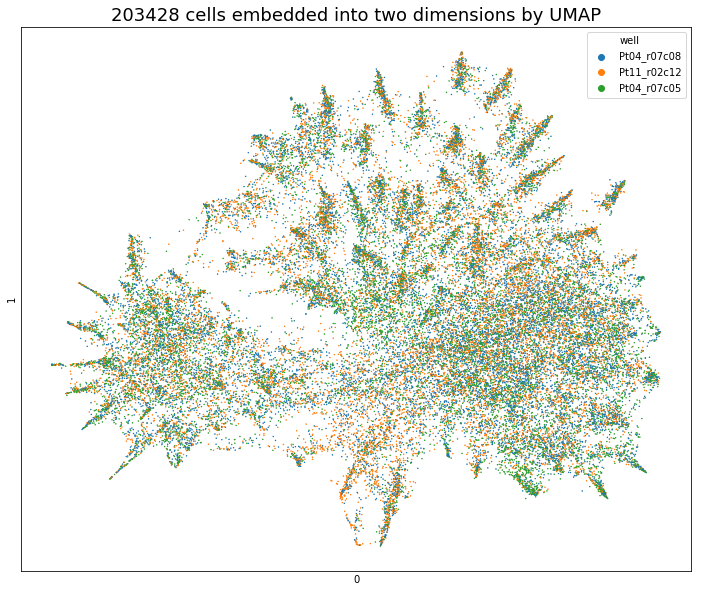

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.well, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

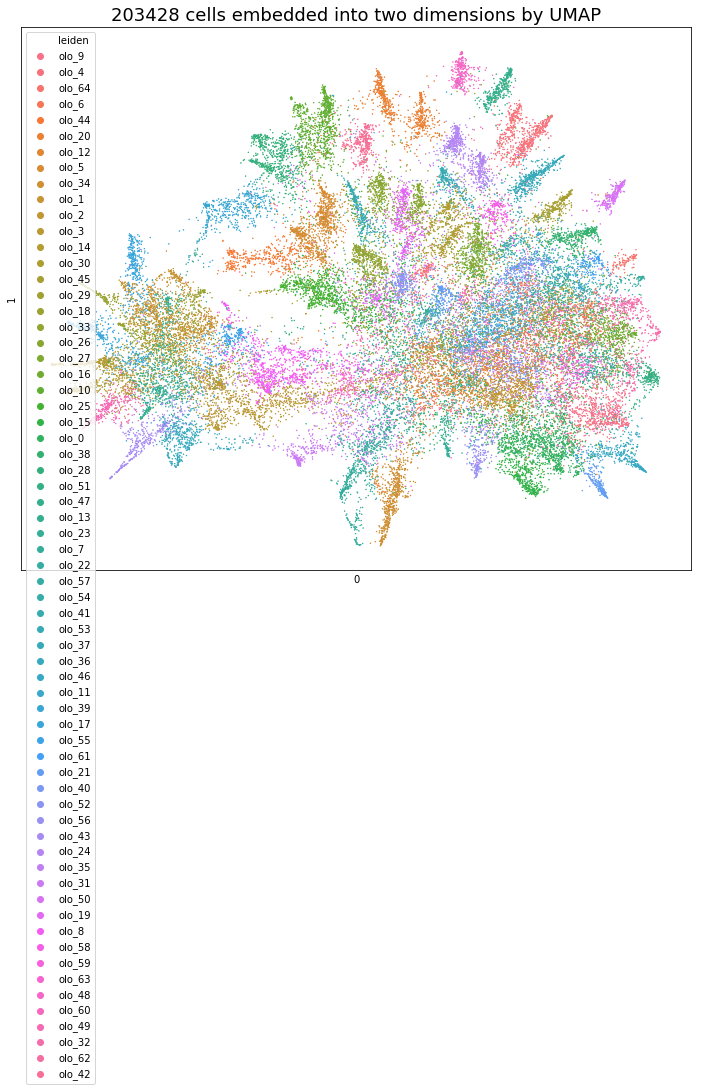

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.leiden, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

### Compare cluster sizes between samples  


In [55]:
## louvain
louvain_ls = []
for well in adata.obs.well.unique():
    sum_well = len(adata.obs.louvain[adata.obs.well == well])
    for i in adata.obs.louvain.unique():
        res = [well, i, len(adata.obs.louvain[(adata.obs.louvain == i) & (adata.obs.well == well)]) / sum_well * 1e4]
        louvain_ls.append(res)

In [56]:
louvain_df = pd.DataFrame(louvain_ls, columns=['well', 'class', 'n_samp'])

In [57]:
louvain_df.head()

,well,class,n_samp
0,Pt04_r07c08,6,131.035465
1,Pt04_r07c08,50,99.700897
2,Pt04_r07c08,98,47.001852
3,Pt04_r07c08,31,126.762569
4,Pt04_r07c08,84,59.820538


In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=louvain_df)

In [77]:
## leiden
leiden_ls = []
for well in adata.obs.well.unique():
    sum_well = len(adata.obs.leiden[adata.obs.well == well])
    for i in adata.obs.leiden.unique():
        res = [well, i, len(adata.obs.leiden[(adata.obs.leiden == i) & (adata.obs.well == well)]) / sum_well * 1e4]
        leiden_ls.append(res)

In [78]:
leiden_df = pd.DataFrame(leiden_ls, columns=['well', 'class', 'n_samp'])

In [79]:
leiden_df.head()

,well,class,n_samp
0,Pt04_r07c08,2,134.596211
1,Pt04_r07c08,56,88.306509
2,Pt04_r07c08,50,80.472867
3,Pt04_r07c08,42,116.792480
4,Pt04_r07c08,86,66.942031


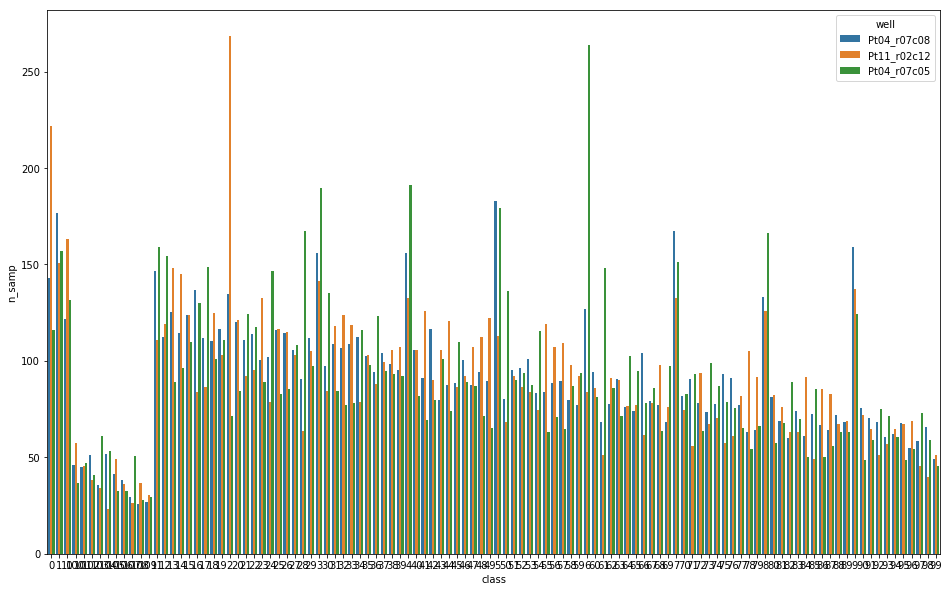

In [80]:
fig, ax = plt.subplots(figsize=(16, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=leiden_df)

### Clusters to export  


In [35]:
import re
import cv2

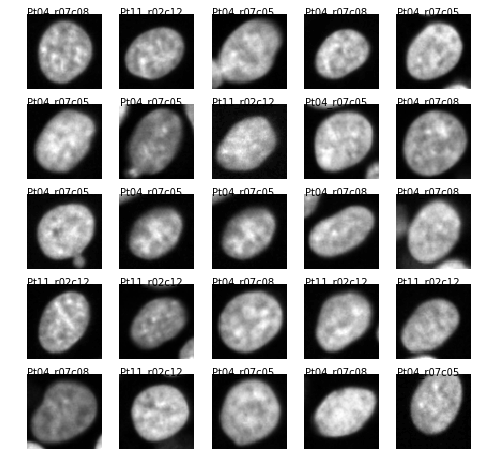

In [91]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for k in range(1, columns * rows + 1):
    select_im = adata.obs.loc[adata.obs.leiden  == '5', 0].to_list()
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)][0]
    img_import = cv2.imread(rand_select, -1)
    subplot = fig.add_subplot(rows, columns, k)
    plt.text(0, 0, s=re.search(r'(Pt\d+_r\d+c\d+)', rand_select)[0])
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')